# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

### Load features and labels into dataframe from csv file 

In [1]:
import zipfile
import os
import pandas as pd

with zipfile.ZipFile('./ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./ecg/')

data = pd.read_csv('./ecg/ecg_data.csv', index_col=0)

file = './ecg/ecg_data.csv'
if(os.path.exists(file) and os.path.isfile(file)):
  os.remove(file)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


### Create test-train split

In [8]:
from sklearn.model_selection import train_test_split

y = data.label
X = data.drop('label', axis=1)

# Need to find logical nubmers for test_size and random_state and add this in the report. 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

### Plotting of training data 

In [21]:
type(X_pca)
X_pca.shape


(578, 3)

<AxesSubplot:>

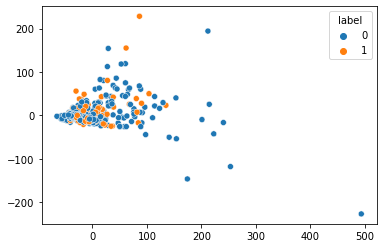

In [34]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import seaborn 

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

pca = decomposition.PCA(n_components=3)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train)

<AxesSubplot:>

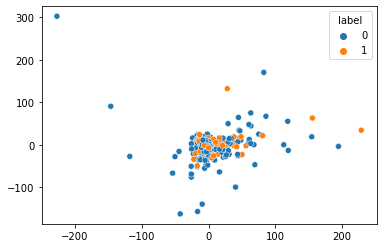

In [35]:
seaborn.scatterplot(x=X_pca[:, 1], y=X_pca[:, 2], hue=y_train)

Inseperable after PCA => need to look into more complex relations between features, linear combinations of features is not enough here; need something more complex. 

### Preprocessing

In [140]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE

scaler = StandardScaler()
random_forest = RandomForestClassifier()
pca = PCA()

# "greedy_featureselection", SequentialFeatureSelector(estimator = random_forest, n_features_to_select=10, cv=2, n_jobs=-1))
#
pipe = Pipeline(steps=[('select', SelectKBest()), ("random_forest", random_forest)])

### Gridsearch for optimal hyperparameters Random Forest Classifer 

In [141]:
from sklearn.model_selection import GridSearchCV

parameters = {'select__k': [2, 5, 10, 20], 'random_forest__n_estimators': [50,100, 500, 1000]}
search = GridSearchCV(pipe, parameters, cv=5, scoring = 'f1', verbose=5)
search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END random_forest__n_estimators=50, select__k=2;, score=0.213 total time=   0.2s
[CV 2/3] END random_forest__n_estimators=50, select__k=2;, score=0.291 total time=   0.2s
[CV 3/3] END random_forest__n_estimators=50, select__k=2;, score=0.235 total time=   0.2s
[CV 1/3] END random_forest__n_estimators=50, select__k=5;, score=0.340 total time=   0.2s
[CV 2/3] END random_forest__n_estimators=50, select__k=5;, score=0.429 total time=   0.2s
[CV 3/3] END random_forest__n_estimators=50, select__k=5;, score=0.327 total time=   0.2s
[CV 1/3] END random_forest__n_estimators=50, select__k=10;, score=0.364 total time=   0.2s
[CV 2/3] END random_forest__n_estimators=50, select__k=10;, score=0.415 total time=   0.2s
[CV 3/3] END random_forest__n_estimators=50, select__k=10;, score=0.327 total time=   0.2s
[CV 1/3] END random_forest__n_estimators=50, select__k=20;, score=0.364 total time=   0.2s
[CV 2/3] END random_forest__n_estim

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('select', SelectKBest()),
                                       ('random_forest',
                                        RandomForestClassifier())]),
             param_grid={'random_forest__n_estimators': [50, 100, 500, 1000],
                         'select__k': [2, 5, 10, 20]},
             scoring='f1', verbose=5)

In [142]:
evaluation_grid= pd.DataFrame(search.cv_results_).sort_values('rank_test_score')
evaluation_grid.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'], axis=1)

,param_random_forest__n_estimators,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
15,1000,20,"{'random_forest__n_estimators': 1000, 'select_...",0.416667,0.428571,0.400000,0.415079,0.011718,1
11,500,20,"{'random_forest__n_estimators': 500, 'select__...",0.382979,0.392157,0.363636,0.379591,0.011887,2
6,100,10,"{'random_forest__n_estimators': 100, 'select__...",0.318182,0.384615,0.431373,0.378057,0.046442,3
7,100,20,"{'random_forest__n_estimators': 100, 'select__...",0.382979,0.423077,0.325581,0.377212,0.040011,4
2,50,10,"{'random_forest__n_estimators': 50, 'select__k...",0.363636,0.415094,0.326531,0.368420,0.036314,5
3,50,20,"{'random_forest__n_estimators': 50, 'select__k...",0.363636,0.423077,0.318182,0.368298,0.042950,6
1,50,5,"{'random_forest__n_estimators': 50, 'select__k...",0.340426,0.428571,0.326531,0.365176,0.045185,7
9,500,5,"{'random_forest__n_estimators': 500, 'select__...",0.340426,0.448276,0.260870,0.349857,0.076798,8
10,500,10,"{'random_forest__n_estimators': 500, 'select__...",0.311111,0.377358,0.333333,0.340601,0.027529,9
14,1000,10,"{'random_forest__n_estimators': 1000, 'select_...",0.238095,0.377358,0.400000,0.338485,0.071585,10


### Evaluation of classifier 

In [138]:
from sklearn.metrics import f1_score, confusion_matrix
best_clf = search.best_estimator_
y_pred = best_clf.predict(X_test)
f1_score(y_test, y_pred)


0.25396825396825395

In [139]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['normal', 'abnormal'], index= ['normal', 'abnormal'])

,normal,abnormal
normal,218,9
abnormal,38,8
